In [1]:
import pandas as pd

import numpy as np

from itertools import combinations

import networkx as nx

import os 

import matplotlib.pyplot as plt

from matplotlib import font_manager as fm, rcParams

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签

plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

pd.set_option("display.max_columns", 50)

pd.set_option("display.max_rows", 260)


In [2]:
# human capital dataframe
hmcpt_df = pd.read_excel('C:/Users/lenovo/a_Research/input/Human_Capital_1.0.0.xlsx')
hmcpt_df.head()

,male,name,year,month,height,blood,homeplace,constellation,academy1,academy2,seniority,no-edu,primer,junior,senior,college,master,higher,parents,spouse,bro-sis,children,teacher,precursor,classmate,Unnamed: 25,quarter,generation,voice actor,Agency Co.,Note
0,1,苏尚卿,1991.0,5.0,NaN,NaN,广西,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,1,杨洋,1991.0,9.0,180.0,AB,上海,处女座,中国人民解放军艺术学院,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,747621.0,NaN,NaN,NaN,0.0,NaN,潘阳
2,1,黄才伦,1985.0,8.0,175.0,NaN,NaN,狮子座,中国人民解放军艺术学院,NaN,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,279200.0,0.0,0.0,NaN,NaN,NaN,0.0,开心麻花,李立群
3,1,朱哲健,1993.0,10.0,182.0,NaN,NaN,NaN,北京电影学院,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1,沈桦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN


### Celebrities Network Establishment

#### Functions Definition

In [16]:
# Data Type Transitions - We filling in the null value in parents, spouse, bro-sis, children columns for further steps

def dt_conv(df, col_list):
    for col in col_list:
        df[col] = df[col].fillna(0).astype('int64')
        
def kinhood_relation_filter(col):
    filter_list = [item for item in col.split(' ') if '(' not in item]
    fin_rel = " ".join(filter_list)
    return(fin_rel)

def network_metric_merge(network, label, iteration = 100):
    
    degree = pd.DataFrame(network.degree).rename(columns={0:'celebrity',1:'degrees'})

    degree_centrality = pd.DataFrame(nx.degree_centrality(network).values(), index = nx.degree_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'degrees_centrality'})

    betweenness_centrality = pd.DataFrame(nx.betweenness_centrality(network).values(), index = nx.betweenness_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'betweenness_centrality'})

    closeness_centrality = pd.DataFrame(nx.closeness_centrality(network).values(), index = nx.closeness_centrality(network).keys()).reset_index().rename(columns={'index':'celebrity',0:'closeness_centrality'})

    eigenvector_centrality = pd.DataFrame(nx.eigenvector_centrality(network, max_iter = iteration).values(), index = nx.eigenvector_centrality(network, max_iter = iteration).keys()).reset_index().rename(columns={'index':'celebrity',0:'eigenvector_centrality'})

    aggregated_dataframe = degree.merge(degree_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(betweenness_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(closeness_centrality, left_on = 'celebrity', right_on = 'celebrity').merge(eigenvector_centrality, left_on = 'celebrity', right_on = 'celebrity')
    
    aggregated_dataframe.loc[:,label] = 1
    
    return(aggregated_dataframe)

kinhood_list = hmcpt_df.columns[18:22]
kinhood_list

dt_conv(hmcpt_df, kinhood_list)

- We add a new column named 'kinhood_indicator' that indicates whether a relative connection exists 

hmcpt_df['kinhood_indicator'] = hmcpt_df[kinhood_list].apply(np.sum,  axis = 1)

kinhood_df = hmcpt_df[hmcpt_df['kinhood_indicator']>0][['name', 'parents', 'spouse', 'bro-sis', 'children', 'kinhood_indicator','Note']].reset_index(drop=True)

kinhood_df

kinhood_df.to_csv('kinhood_validation.csv')

#### Network Building

In [19]:
kin_hood_df = pd.read_csv('C:/Users/lenovo/a_Research/input/Kinhood_Data.csv', encoding='GBK', index_col=0)

kin_hood_df

,name,parents,spouse,bro-sis,children,kinhood_indicator,teacher,precursor,classmate,Note
0,吴京,0,7452483,0,0,7452483,0,0.0,0,谢楠
1,冯小刚,0,1,0,0,1,0,0.0,0,徐帆
2,梁朝伟,0,18676115,0,0,18676115,1,292313.0,0,刘嘉玲 周星驰(同学) 曾华倩(前女友)
3,李连杰,0,1,0,0,1,0,1.0,0,利智 黄秋燕(前妻)
4,张震,1,0,28511,0,28512,0,30578709.0,0,张国柱 张翰 庄雯如 舒淇(前女友)
5,葛优,1,0,0,0,1,0,0.0,0,葛存壮
6,邓超,0,40778647,0,0,40778647,0,0.0,0,孙俪
7,赵又廷,781392,43351659,0,0,44133051,0,0.0,0,赵树海 高圆圆
8,陈赫,1,5465856,0,0,5465857,0,0.0,1056826,胡小玲 张子萱 郑恺(同学)
9,姜文,0,1,1630808,0,1630809,0,3641450.0,3213779,周韵 姜武 吕丽萍(同学) 岳红(同学) 刘斌(同学)


- We add a new column named as 'Relatives' that only keep relatives

In [20]:
kin_hood_df['Relatives'] = kin_hood_df['Note'].apply(kinhood_relation_filter)

In [21]:
kin_hood_df = kin_hood_df[~(kin_hood_df.Relatives == '')].reset_index(drop=True)

- We add a new column named as 'Name_List_fin' that keep the name of the name and Relatives: eg: |吴京 谢楠|

In [22]:
kin_hood_df['Name_List_fin'] = (kin_hood_df['name'] + ' ' + kin_hood_df['Relatives']).apply(lambda x: x.split(' '))

- We add a new column named as 'network_tuple' that combines two of figures in Name_List together as a tuple in iterations eg: |[(陈赫, 胡小玲), (陈赫, 张子萱), (胡小玲, 张子萱)]|

In [23]:
kin_hood_df.loc[:,'network_tuple'] = kin_hood_df['Name_List_fin'].apply(lambda x: [*combinations(x, 2)])

#### Creating nodes & adding nodes

In [24]:
# taking a look at the first 5 rows of the list of tuples
kin_hood_df['network_tuple'].iloc[:5]

0                                           [(吴京, 谢楠)]
1                                          [(冯小刚, 徐帆)]
2                                         [(梁朝伟, 刘嘉玲)]
3                                          [(李连杰, 利智)]
4    [(张震, 张国柱), (张震, 张翰), (张震, 庄雯如), (张国柱, 张翰), (张...
Name: network_tuple, dtype: object

- We initiate an empty graph

In [25]:
kin_network = nx.Graph()

In [26]:
kin_hood_df

,name,parents,spouse,bro-sis,children,kinhood_indicator,teacher,precursor,classmate,Note,Relatives,Name_List_fin,network_tuple
0,吴京,0,7452483,0,0,7452483,0,0.0,0,谢楠,谢楠,"[吴京, 谢楠]","[(吴京, 谢楠)]"
1,冯小刚,0,1,0,0,1,0,0.0,0,徐帆,徐帆,"[冯小刚, 徐帆]","[(冯小刚, 徐帆)]"
2,梁朝伟,0,18676115,0,0,18676115,1,292313.0,0,刘嘉玲 周星驰(同学) 曾华倩(前女友),刘嘉玲,"[梁朝伟, 刘嘉玲]","[(梁朝伟, 刘嘉玲)]"
3,李连杰,0,1,0,0,1,0,1.0,0,利智 黄秋燕(前妻),利智,"[李连杰, 利智]","[(李连杰, 利智)]"
4,张震,1,0,28511,0,28512,0,30578709.0,0,张国柱 张翰 庄雯如 舒淇(前女友),张国柱 张翰 庄雯如,"[张震, 张国柱, 张翰, 庄雯如]","[(张震, 张国柱), (张震, 张翰), (张震, 庄雯如), (张国柱, 张翰), (张..."
5,葛优,1,0,0,0,1,0,0.0,0,葛存壮,葛存壮,"[葛优, 葛存壮]","[(葛优, 葛存壮)]"
6,邓超,0,40778647,0,0,40778647,0,0.0,0,孙俪,孙俪,"[邓超, 孙俪]","[(邓超, 孙俪)]"
7,赵又廷,781392,43351659,0,0,44133051,0,0.0,0,赵树海 高圆圆,赵树海 高圆圆,"[赵又廷, 赵树海, 高圆圆]","[(赵又廷, 赵树海), (赵又廷, 高圆圆), (赵树海, 高圆圆)]"
8,陈赫,1,5465856,0,0,5465857,0,0.0,1056826,胡小玲 张子萱 郑恺(同学),胡小玲 张子萱,"[陈赫, 胡小玲, 张子萱]","[(陈赫, 胡小玲), (陈赫, 张子萱), (胡小玲, 张子萱)]"
9,姜文,0,1,1630808,0,1630809,0,3641450.0,3213779,周韵 姜武 吕丽萍(同学) 岳红(同学) 刘斌(同学),周韵 姜武,"[姜文, 周韵, 姜武]","[(姜文, 周韵), (姜文, 姜武), (周韵, 姜武)]"


- ad_hoc, to see the difference between everything
df1 = hmcpt_df[['name','Note']]
df2 = .rename(columns={'name': 'name_kin','Note':'Note_2'})
df_merged_adhoc = hmcpt_df[['name','Note']].merge(kin_hood_df[['name','Note']], left_on='name',right_on='name_kin', how='inner')

df_merged_adhoc

In [27]:
# We created a list made up of people with no repetition 
nodes_list = kin_hood_df.Name_List_fin.sum()

nodes_list = list(set(nodes_list))

print(len(nodes_list))

kin_network.add_nodes_from(nodes_list)

325


In [28]:
edges_list = kin_hood_df.network_tuple.sum()

kin_network.add_edges_from(edges_list)

https://networkx.org/documentation/latest/index.html

#### Null value and self-join validation

In [29]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)]

[]

#### Centrality Calculation

In [30]:
aggregated_kinhood_network_metrics = network_metric_merge(kin_network, 'kinhood_network_indicator')

aggregated_kinhood_network_metrics.head()

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,kinhood_network_indicator
0,谢钢,1,0.003086,0.0,0.003086,3.407046e-13,1
1,蔡明,1,0.003086,0.0,0.003086,3.407046e-13,1
2,徐坚,3,0.009259,0.0,0.009877,7.730499e-05,1
3,莫文蔚,1,0.003086,0.0,0.003086,3.407046e-13,1
4,陈建斌,1,0.003086,0.0,0.003086,3.407046e-13,1


In [31]:
aggregated_kinhood_network_metrics.to_csv('~/a_Research/Output/aggregated_kinhood_network_metrics.csv', index = False)

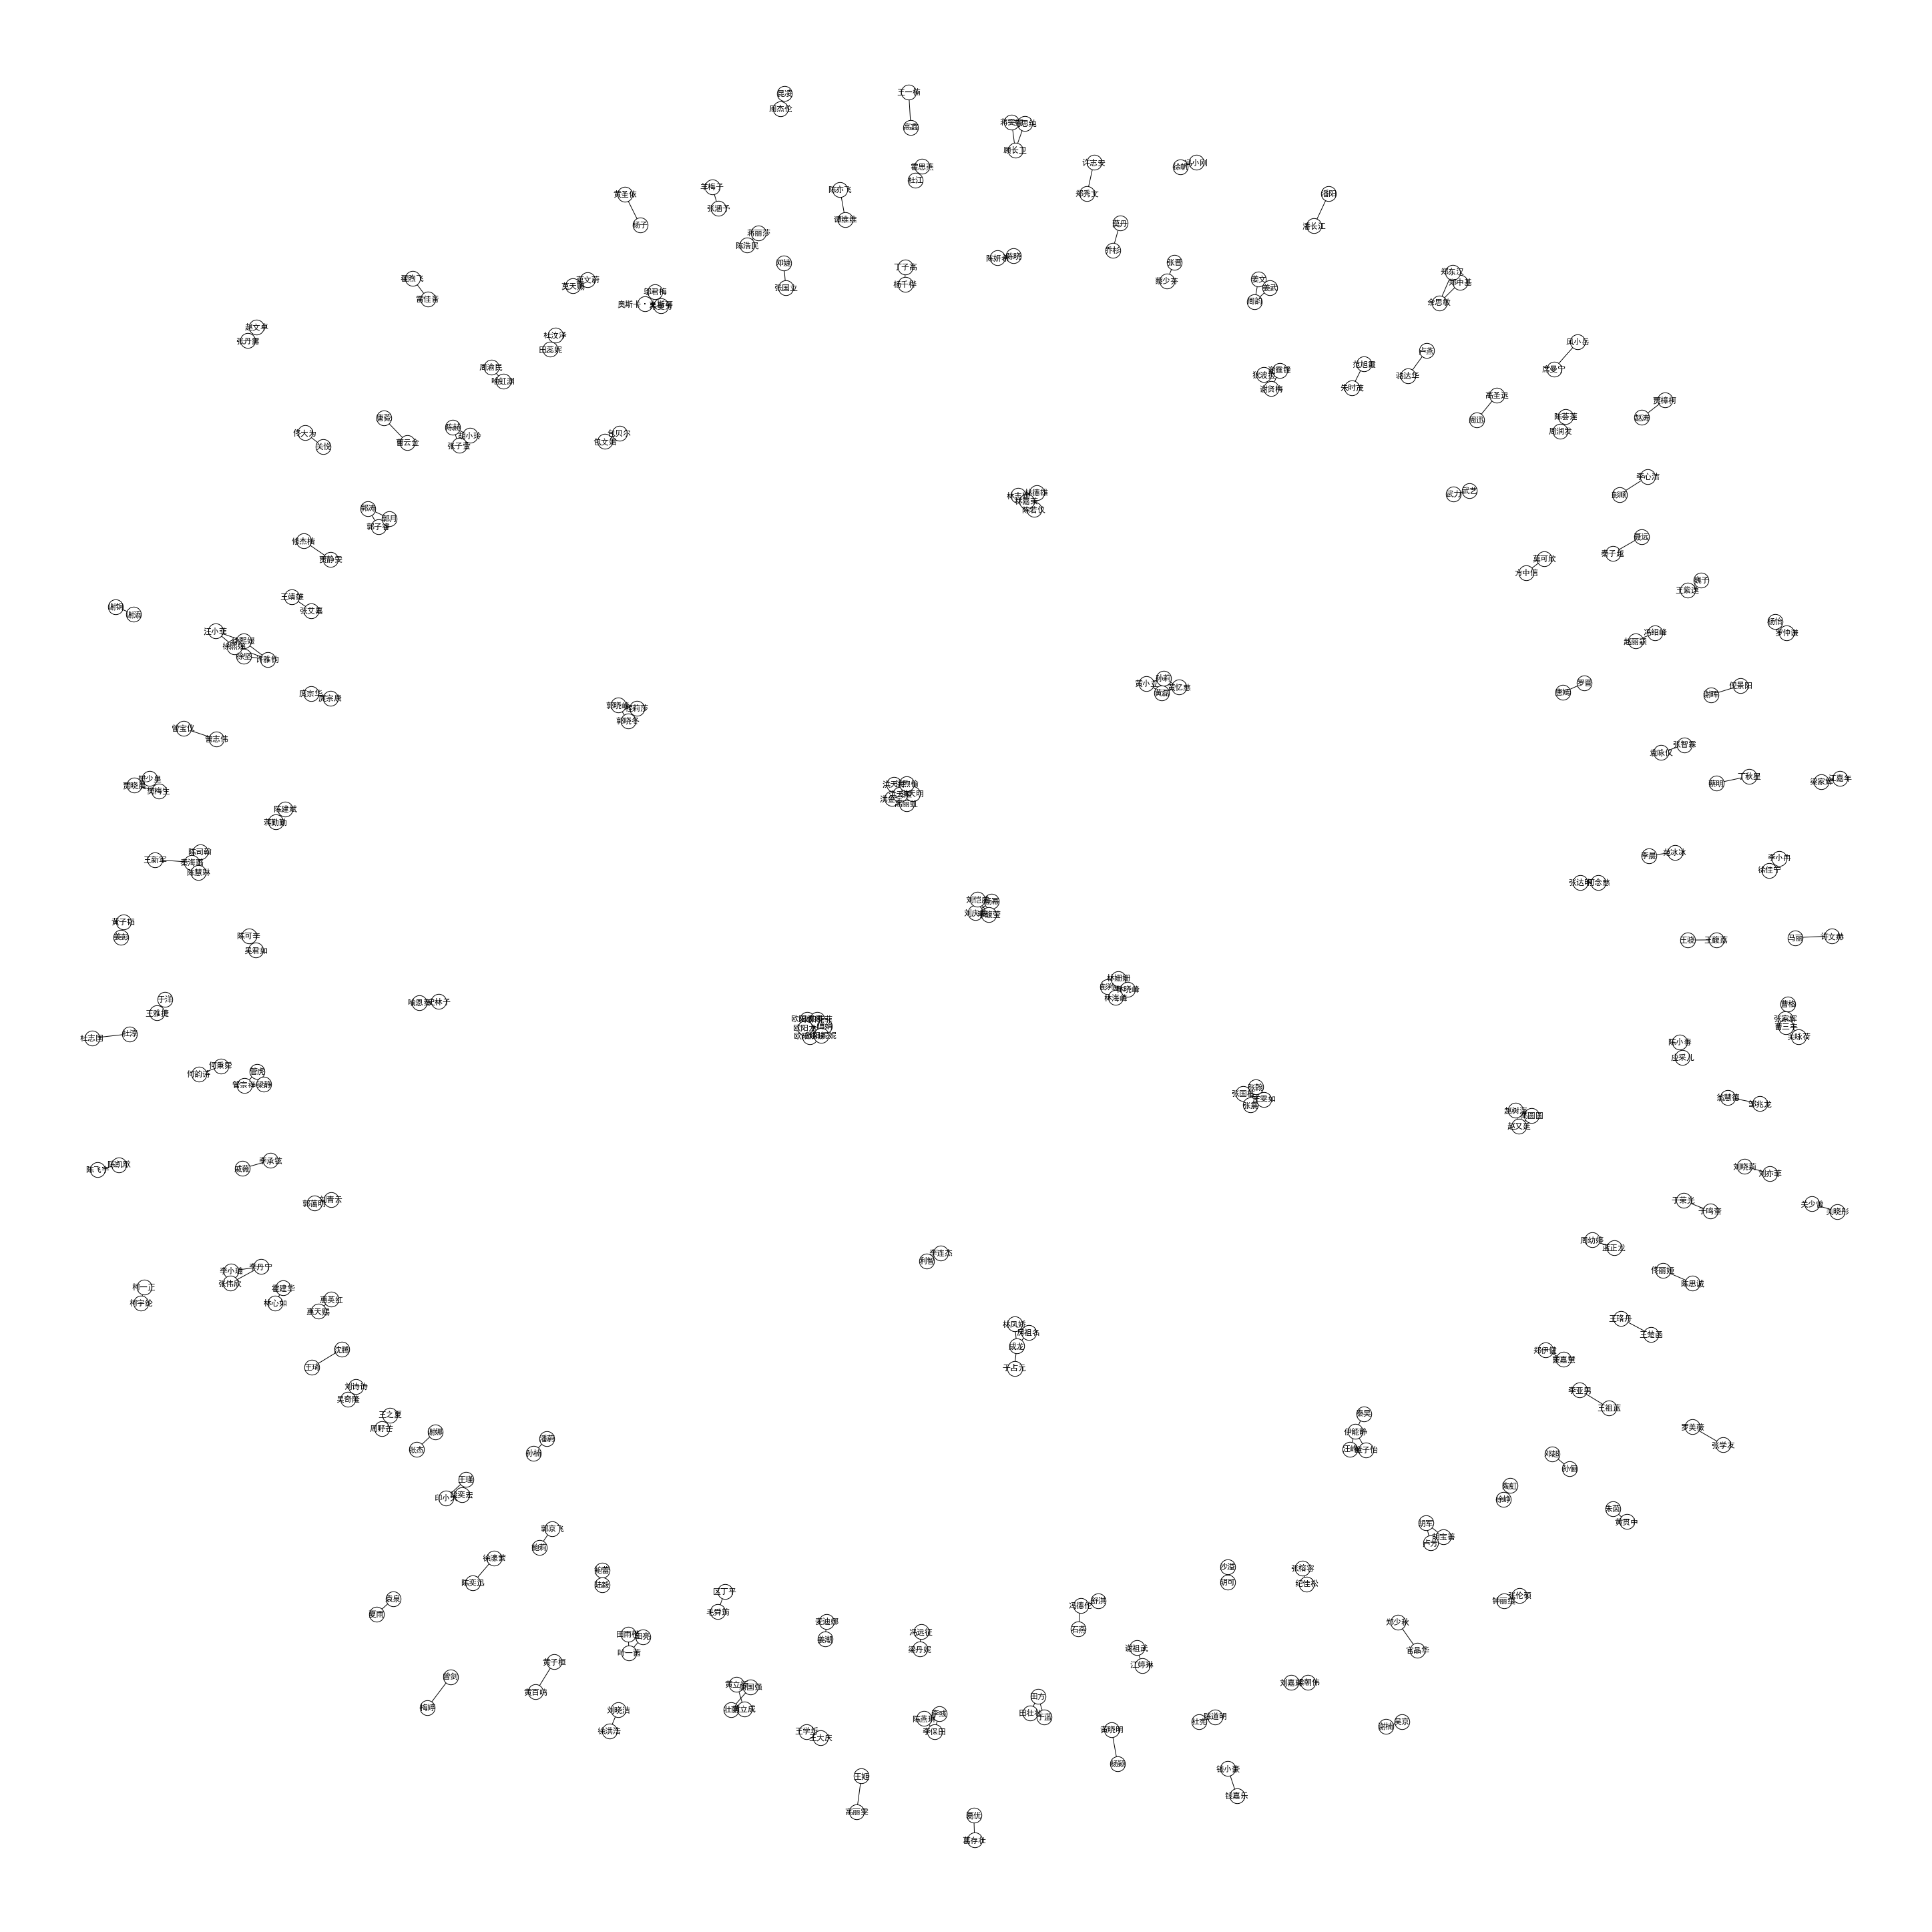

In [24]:
pos = nx.spring_layout(kin_network, scale=2, seed = 50)

plt.figure(figsize=(40,40)) 

options = {
    "font_size": 12,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black" ,   "width": 1,
}

nx.draw(kin_network,pos = pos, with_labels = True, **options)

plt.show()

'老师','同学','前女友','前妻','前夫','前男友','干女儿', '干儿子','舅父','嫂子','圈外'

### Alumni Network Building
- We have three way to identify alumni, 1st is the classmate indicator, 2nd is note column that specify, 3rd is the same school they went to, we will use three seperate ways to identify this link
- Further way to conduct this test is to make the connection more closer by using clumni and classmates, the later one could be more meaningful

- First, we select out the classmate information at our disposal

dt_conv(hmcpt_df, ['classmate'])

hmcpt_df['classmate_indicator'] = np.where(hmcpt_df['classmate'] > 0, 1, 0)

classmate_df = hmcpt_df[hmcpt_df['classmate_indicator'] > 0][['name','parents', 'spouse', 'bro-sis', 'children', 'classmate','classmate_indicator','Note']].reset_index(drop=True)

info_combination_df = classmate_df.merge(kin_hood_df[['name','Note']], left_on = 'name', right_on = 'name', how = 'left')

info_combination_df['kinhood_indicator'] = info_combination_df[kinhood_list].apply(np.sum,  axis = 1)

info_combination_df.loc[:, ['Note_x', 'Note_y']] = info_combination_df[['Note_x', 'Note_y']].fillna('Null')

def Combining_Note(df,col1,col2):
    
    df['Combined_Note'] = 'Null'

    df.loc[((col1 == 'Null') & (col2 == 'Null')), 'Combined_Note'] = 'Null'

    df.loc[((col1 == 'Null') & (col2 != 'Null')), 'Combined_Note'] = col2

    df.loc[((col1 != 'Null') & (col2 != 'Null')), 'Combined_Note'] = col2

    df.loc[((col1 != 'Null') & (col2 == 'Null')), 'Combined_Note'] = col1

Combining_Note(info_combination_df, info_combination_df.Note_x, info_combination_df.Note_y)

info_combination_df[['name', 'classmate_indicator','kinhood_indicator','Combined_Note']].to_csv('~/a_Research/Input/Alumni_Data.csv')

https://towardsdatascience.com/python-interactive-network-visualization-using-networkx-plotly-and-dash-e44749161ed7

https://towardsdatascience.com/getting-started-with-graph-analysis-in-python-with-pandas-and-networkx-5e2d2f82f18e

https://towardsdatascience.com/tutorial-network-visualization-basics-with-networkx-and-plotly-and-a-little-nlp-57c9bbb55bb9

#### Functions Definitions


In [91]:
def student_relation_filter(col):
    filter_list = [item.replace("(同学)","") for item in col.split(' ') if '同学' in item]    
    if len(filter_list) == 0:
        fin_rel = np.NaN
    else:
        fin_rel = " ".join(filter_list)
    return(fin_rel)

class_mate_df = pd.read_csv('~/a_Research/Input/Alumni_Data.csv', encoding='GBK', index_col=0)

class_mate_df['Alumni'] = class_mate_df['Combined_Note'].apply(student_relation_filter)

class_mate_df = class_mate_df[~class_mate_df['Alumni'].isna()].reset_index(drop=True)

class_mate_df['Name_List_fin'] = (class_mate_df['name'] + ' ' + class_mate_df['Alumni']).apply(lambda x: x.split(' '))

class_mate_df.loc[:,'network_tuple'] = class_mate_df['Name_List_fin'].apply(lambda x: [*combinations(x, 2)])

class_mate_df.head()

academy_df = hmcpt_df[~hmcpt_df['academy1'].isna() | ~hmcpt_df['academy2'].isna()].reset_index(drop=True)

academy_df = academy_df[['name','academy1','academy2']].set_index('name')

academy_df.head()

modified_test_df = academy_df.stack().reset_index(level=1,drop=True)

modified_test_df = modified_test_df.reset_index().rename(columns={0:'academy'})

modified_test_df

# academy_list = sorted(list(set(modified_test_df.academy.to_list())))

mapping_table = {'台湾市华岗艺术学校': '华冈艺校','华冈艺术学校': '华冈艺校','北京大学艺术学院':'北京大学','广东亚视演艺学院':'广东亚视演艺职业学院'}



In [92]:
modified_df = modified_test_df.copy()


In [ ]:


### This command builds a graph B with the egdes in the DataFrame
### we've just created
B= nx.from_pandas_edgelist(modified_test_df, 'name', 'academy')

### But it is not a bipartite graph yet..
### We need to tell NetworkX explicitly what nodes belong to which set.

### Let's add the nodes in the restaurant columns and declare that they are
### in the bipartite set 0
B.add_nodes_from(modified_test_df['name'], bipartite=0)
### Let's add the nodes in the 0 columns and declare that they are
### in the bipartite set 1
B.add_nodes_from(modified_test_df['academy'], bipartite=1)

Actors = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
Aademy = set(B) - Actors

### Let's plot the bipartite graph
import matplotlib.pyplot as plt

### Here we are going to display one set at horizontal position 1 
### and the other at position 2
### Check the documentation for nx.draw to learn about these options
plt.figure(3,figsize=(10,10)) 
pos= dict()
pos.update( (n, (1, 20*i)) for i, n in enumerate(Aademy) ) # put nodes from X at x=1
pos.update( (n, (2, 10*i)) for i, n in enumerate(Actors) ) # put nodes from Y at x=2
nx.draw(B, pos=pos, node_size=2, width=0.1,with_labels=True)
plt.show()

In [93]:
modified_df['academy'] = [item if item not in mapping_table.keys() else mapping_table[item] for item in modified_df.academy]


In [94]:
modified_df['peoplelist'] = modified_df['name'].apply(lambda x: x.split())
    
agg = modified_df.groupby('academy')['peoplelist'].agg(sum)

In [95]:
agg = agg.apply(pd.unique)

In [96]:
academy_agg_df = agg.reset_index()

academy_agg_df['network_tuple'] = academy_agg_df['peoplelist'].apply(lambda x: [*combinations(x, 2)])

In [38]:
academy_agg_df

,academy,peoplelist,network_tuple
0,上海东方文化学院,[黄奕],[]
1,上海师范大学,"[范冰冰, 赵奕欢]","[(范冰冰, 赵奕欢)]"
2,上海戏剧学院,"[袁文康, 陈赫, 徐峥, 彭昱畅, 徐洪浩, 雷佳音, 冯绍峰, 林更新, 廖凡, 佟大为...","[(袁文康, 陈赫), (袁文康, 徐峥), (袁文康, 彭昱畅), (袁文康, 徐洪浩),..."
3,上海戏剧学院附属戏剧学校,[李沁],[]
4,上海戏曲学院,[王驾麟],[]
5,上海理工大学,[洪海天],[]
6,上海电机学院,[乔任梁],[]
7,上海视觉艺术学院,[姚一奇],[]
8,上海音乐学院,[陈学冬],[]
9,世新大学,"[刘德凯, 赖雅妍, 张榕容]","[(刘德凯, 赖雅妍), (刘德凯, 张榕容), (赖雅妍, 张榕容)]"


In [39]:
class_mate_df.head()

,name,classmate_indicator,kinhood_indicator,Combined_Note,Alumni,Name_List_fin,network_tuple
0,杨洋,1,0,毛若懿(同学),毛若懿,"[杨洋, 毛若懿]","[(杨洋, 毛若懿)]"
1,陈赫,1,5465857,胡小玲 张子萱 郑恺(同学),郑恺,"[陈赫, 郑恺]","[(陈赫, 郑恺)]"
2,姜文,1,1630809,周韵 姜武 吕丽萍(同学) 岳红(同学) 刘斌(同学),吕丽萍 岳红 刘斌,"[姜文, 吕丽萍, 岳红, 刘斌]","[(姜文, 吕丽萍), (姜文, 岳红), (姜文, 刘斌), (吕丽萍, 岳红), (吕丽..."
3,雷佳音,1,59815,翟煦飞 孙艺洲(同学),孙艺洲,"[雷佳音, 孙艺洲]","[(雷佳音, 孙艺洲)]"
4,林更新,1,0,周放(同学) 蒲巴甲(同学),周放 蒲巴甲,"[林更新, 周放, 蒲巴甲]","[(林更新, 周放), (林更新, 蒲巴甲), (周放, 蒲巴甲)]"


In [97]:
ttl_agg_tuple = academy_agg_df.network_tuple.sum()

empty_list = []

for item in ttl_agg_tuple:
    empty_list.append(item[0])
    empty_list.append(item[1])

In [98]:
empty_list = list(set(empty_list))

In [99]:
alumni_network = nx.Graph()

nodes_list = class_mate_df.Name_List_fin.sum()

nodes_list = list(set(nodes_list))

nodes_list.extend(empty_list)

nodes_list = list(set(nodes_list))

print(len(nodes_list))

alumni_network.add_nodes_from(nodes_list)

edges_list = class_mate_df.network_tuple.sum()

edges_list.extend(academy_agg_df.network_tuple.sum())

edges_list = list(set(edges_list))

alumni_network.add_edges_from(edges_list)

448


#### Null value and self-join validations

In [100]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)]

[]

#### Centrality Calculation

In [101]:
aggregated_alumni_network_metrics = network_metric_merge(alumni_network, 'alumni_network_indicator', 10000)

aggregated_alumni_network_metrics.head()

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,alumni_network_indicator
0,白敬亭,1,0.002237,0.000000,0.002237,1.996833e-310,1
1,谢钢,174,0.389262,0.173263,0.435559,1.366962e-01,1
2,周圣崴,2,0.004474,0.000000,0.220978,4.640166e-04,1
3,潘之琳,88,0.196868,0.000000,0.300385,9.768308e-02,1
4,蔡明,88,0.196868,0.000000,0.300385,9.768308e-02,1


In [102]:
aggregated_alumni_network_metrics.to_csv('~/a_Research/Output/aggregated_alumni_network_metrics.csv', index = False)

In [ ]:
pos = nx.spring_layout(alumni_network, scale=2)

plt.figure(figsize=(40,40)) 

options = {
    "font_size": 12,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black" ,   "width": 1,
}

nx.draw(alumni_network,pos = pos, with_labels = True, **options)

plt.show()

### Co-worker's Network Building

In [47]:
df = pd.read_csv('~/a_Research/Input/table_mod_dec_20.csv', encoding = "GBK", header=1)

df.head()

,code,year,month,name,box2019,box,director1,director2,dfans,dst,ms1,ms1fans,ms1st,fs1,fs1fans,fs1st,ms2,ms2fans,ms2st,fs2,fs2fans,fs2st,guests,gsfans,gst,type,love,crime,history,other,family,animated,comedy,action,jjuj,jjij,hbij,jxiaj,jmaj,jluj,bhuj,jxioj,rank,total,sequels,remake,prize
0,1,2009,9,建国大业,5.369108,4.16,韩三平,黄建新,5456.0,2011/3/23,唐国强,37179.0,2011/3/12,许晴,8381242.0,2011/3/23,张国立,475478.0,2011/3/13,邬君梅,403431.0,2010/3/2,陈坤,78031895.0,2009/11/13,历史、战争,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,6.1,111541.0,0.0,1.0,2011华表奖优秀故事片奖、2010金鹿奖最佳华语故事片、2010百花奖最佳影片奖
1,2,2009,12,十月围城,3.755794,2.91,陈德森,NaN,545022.0,2010/3/9,甄子丹,6078838.0,2010/3/30,范冰冰,39431925.0,2013/12/25,梁家辉,0.0,NaN,李宇春,3517480.0,2009/9/10,谢霆锋,NaN,NaN,历史、战争,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,7.7,204435.0,0.0,1.0,2011华表奖优秀合拍片奖、2010金像奖最佳电影第47届台湾电影金马奖
2,3,2009,1,赤壁(下),3.368599,2.61,吴宇森,NaN,233738.0,2015/7/16,梁朝伟,1504853.0,2010/5/27,赵薇,73974278.0,2009/10/28,金城武,0.0,NaN,林志玲,9901922.0,2009/8/28,佟大为,22612580.0,2009/8/28,历史、战争,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,6.5,84042.0,1.0,1.0,2009华表奖优秀合拍片奖，香港金像奖最佳剪接
3,4,2009,12,三枪拍案惊奇,3.329879,2.58,张艺谋,NaN,0.0,NaN,孙红雷,11381520.0,2009/9/29,闫妮,377610.0,2011/6/28,小沈阳,12835247.0,2009/8/28,NaN,NaN,NaN,赵本山,5524638.0,2010/11/20,惊悚、悬疑、犯罪,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.7,68824.0,0.0,0.0,NaN
4,5,2009,9,风声,2.891058,2.24,高群书,陈国富,0.0,NaN,黄晓明,39327844.0,2010/4/14,周迅,4309367.0,2011/5/4,苏有朋,22655876.0,2010/12/14,李冰冰,35118659.0,2009/8/28,张涵予,636765.0,2009/8/28,惊悚、悬疑、犯罪,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,8.0,234005.0,0.0,1.0,2011华表奖优秀合拍片奖第30届百花奖第46届金马奖


In [48]:
# Not sure whether this should be a constraint , 2254 films get deleted

df = df[df['box2019'] > df['box2019'].quantile(.5)].reset_index(drop=True)

### Dropping unncessary columns for this stage - Graph Building

In [49]:
attr_list = ['year','name','box2019','director1','director2','ms1', 'fs1','ms2','fs2','guests']

df = df[~df['type'].str.contains('动画')][attr_list].reset_index(drop=True)

df.head()

,year,name,box2019,director1,director2,ms1,fs1,ms2,fs2,guests
0,2009,建国大业,5.369108,韩三平,黄建新,唐国强,许晴,张国立,邬君梅,陈坤
1,2009,十月围城,3.755794,陈德森,NaN,甄子丹,范冰冰,梁家辉,李宇春,谢霆锋
2,2009,赤壁(下),3.368599,吴宇森,NaN,梁朝伟,赵薇,金城武,林志玲,佟大为
3,2009,三枪拍案惊奇,3.329879,张艺谋,NaN,孙红雷,闫妮,小沈阳,NaN,赵本山
4,2009,风声,2.891058,高群书,陈国富,黄晓明,周迅,苏有朋,李冰冰,张涵予


In [50]:
# Change the data type into string
df.loc[:, ['name', 'director1', 'director2', 'ms1', 'fs1', 'ms2', 'fs2',
       'guests']] = df[['name', 'director1', 'director2', 'ms1', 'fs1', 'ms2', 'fs2',
       'guests']].astype('str')

In [51]:
for attr in attr_list[1:]:
    
    if attr != 'box2019':
        
        df.loc[:, attr] = df[attr].apply(lambda x: x.lstrip().rstrip().replace(' ',',').lstrip(' ').rstrip(' '))

df = df[~df['director1'].str.contains('nan')].reset_index(drop=True)

In [52]:
[stuff for stuff in df['director2'] if len(stuff) > 4 ]

['九把刀,黄子佼,陈奕先',
 '王卡劳,殷慧君,周红',
 '田壮壮,张艺谋',
 '潘安子,章家瑞,宋迪在',
 '董润年,韩轶,傅天余,冀佳彤',
 '杜林,李锐,王骏',
 '李光浩,千丙哲',
 '陈世杰,西瓦罗·孔萨库',
 '沃尔特·塞勒斯',
 '阿迪夏·夏热合曼']

In [53]:
df.loc[:, 'co_acts'] = df['director1'] + ',' + df['director2'] + ',' + df['ms1'] + ',' + df['fs1'] + ',' + df['ms2'] + ',' + df['fs2'] + ',' +  df['guests']

df.loc[:, 'co'] = df['ms1'] + ',' + df['fs1'] + ',' + df['ms2'] + ',' + df['fs2'] + ',' +  df['guests']

In [54]:
df.loc[:, 'co_acts'] = df['co_acts'].apply(lambda x: x.replace('nan,', '').replace(',nan','').split(','))

df.loc[:, 'co'] = df['co'].apply(lambda x: x.replace('nan,', '').replace(',nan','').split(','))

df['indicator'] = [1 if a in b else 0 for a, b in zip(df['director1'], df['co'])]

In [55]:
df_bi = df[['year','co_acts','indicator']]

df_bi.loc[:, 'collab'] = df_bi['co_acts'].apply(lambda x: [*combinations(x, 2)])

# df_bi[df_bi.loc[:,'indicator'] == 1]

# df_bi.iloc[df[df['director1'] == '王宝强'].index]

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [56]:
celebrity_network = nx.Graph()

In [57]:
nodes_list = df.co_acts.sum()

print(len(nodes_list))

nodes_list = list(set(nodes_list))

print(len(nodes_list))

celebrity_network.add_nodes_from(nodes_list)

edges_list = df_bi.collab.sum()

# June.3rd, we've taken care of the self-join

# edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

celebrity_network.add_edges_from(edges_list)

5760
2450


In [88]:
def yearly_graph(year):
    
    df_bi_year = df_bi[df_bi.year <= year].reset_index(drop=True)
    
    yearly_graph = nx.Graph()
    
    nodes_list = df_bi_year.co_acts.sum()

    nodes_list = list(set(nodes_list))

    yearly_graph.add_nodes_from(nodes_list)

    edges_list = df_bi_year.collab.sum()

    # June.3rd, we've taken care of the self-join

    # edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

    yearly_graph.add_edges_from(edges_list)
    
    return(network_metric_merge(yearly_graph, 'year', 50000))

In [90]:
for item in range(2009, 2020):
    
    calculation = yearly_graph(item)
    
    calculation.to_csv(f'~/a_Research/Output/aggregated_collaboration_network_metrics_{item}.csv', index = False)



In [58]:
[item for item in edges_list if item[0] == item[1] or (len(item[0]) == 0) or (len(item[1]) == 0)]

[('吴镇宇', '吴镇宇'),
 ('刘仪伟', '刘仪伟'),
 ('俞飞鸿', '俞飞鸿'),
 ('秦海璐', '秦海璐'),
 ('姜文', '姜文'),
 ('徐静蕾', '徐静蕾'),
 ('黄百鸣', '黄百鸣'),
 ('王力宏', '王力宏'),
 ('曾志伟', '曾志伟'),
 ('柳云龙', '柳云龙'),
 ('郭德纲', '郭德纲'),
 ('张瑜', '张瑜'),
 ('徐静蕾', '徐静蕾'),
 ('成龙', '成龙'),
 ('曾志伟', '曾志伟'),
 ('朱时茂', '朱时茂'),
 ('徐峥', '徐峥'),
 ('成龙', '成龙'),
 ('王一楠', '王一楠'),
 ('舒淇', '舒淇'),
 ('徐正超', '徐正超'),
 ('周杰伦', '周杰伦'),
 ('邓超', '邓超'),
 ('姜文', '姜文'),
 ('陈思诚', '陈思诚'),
 ('肖央', '肖央'),
 ('午马', '午马'),
 ('李彧', '李彧'),
 ('戴维', '戴维'),
 ('徐峥', '徐峥'),
 ('董成鹏', '董成鹏'),
 ('邓超', '邓超'),
 ('吴京', '吴京'),
 ('徐静蕾', '徐静蕾'),
 ('陈诚', '陈诚'),
 ('周星驰', '周星驰'),
 ('陈建斌', '陈建斌'),
 ('胡耀辉', '胡耀辉'),
 ('刘镇伟', '刘镇伟'),
 ('洪金宝', '洪金宝'),
 ('岳松', '岳松'),
 ('陈天星', '陈天星'),
 ('王良', '王良'),
 ('吴京', '吴京'),
 ('王宝强', '王宝强'),
 ('董成鹏', '董成鹏'),
 ('吴君如', '吴君如'),
 ('李晨', '李晨'),
 ('赵汉唐', '赵汉唐'),
 ('卢正雨', '卢正雨'),
 ('徐静蕾', '徐静蕾'),
 ('黄磊', '黄磊'),
 ('张艾嘉', '张艾嘉'),
 ('黎明', '黎明'),
 ('高晓攀', '高晓攀'),
 ('黄渤', '黄渤'),
 ('姜文', '姜文'),
 ('包贝尔', '包贝尔'),
 ('小沈阳', '小沈阳'),
 ('肖央', '肖央'),
 ('冯巩', '冯巩'),
 ('张家辉', '张家辉')

In [ ]:
pos = nx.spring_layout(celebrity_network, scale=2)

plt.figure(figsize=(40,40)) 

options = {
    "font_size": 12,
    "node_size": 500,
    "node_color": "white",
    "edgecolors": "black" ,   "width": 1,
}

nx.draw(celebrity_network,pos = pos, with_labels = True, **options)

plt.show()

#### Centrality Calculation

In [59]:
aggregated_collaboration_network_metrics = network_metric_merge(celebrity_network, 'collaboration_network_indicator', 100000)

aggregated_collaboration_network_metrics.head()

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,collaboration_network_indicator
0,冯大年,3,0.001225,0.000000,0.001225,2.091023e-13,1
1,严屹宽,6,0.002450,0.000167,0.238161,2.745707e-03,1
2,宁瀛,4,0.001633,0.000000,0.227987,2.161842e-03,1
3,马里奥·毛瑞尔,4,0.001633,0.000000,0.200051,3.958424e-04,1
4,胡崇曦,5,0.002042,0.000000,0.223094,1.575159e-03,1


In [60]:
aggregated_collaboration_network_metrics[aggregated_collaboration_network_metrics.celebrity == '张艺谋']

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,collaboration_network_indicator
2286,张艺谋,29,0.011842,0.002226,0.297469,0.045673,1


In [61]:
aggregated_collaboration_network_metrics.to_csv('~/a_Research/Output/aggregated_collaboration_network_metrics.csv', index = False)

In [62]:
aggregated_collaboration_network_metrics.sort_values(by=['degrees'],ascending=False)

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,collaboration_network_indicator
2349,古天乐,124,0.050633,0.037426,0.348483,2.166384e-01,1
872,任达华,95,0.038791,0.031909,0.330499,1.218994e-01,1
2041,黄渤,82,0.033483,0.020855,0.336322,1.292117e-01,1
2066,黄晓明,81,0.033075,0.014920,0.324344,1.320251e-01,1
1086,郭富城,81,0.033075,0.014777,0.322134,1.332160e-01,1
...,...,...,...,...,...,...,...
743,闫东,0,0.000000,0.000000,0.000000,3.115867e-21,1
1393,赵崇邦,0,0.000000,0.000000,0.000000,3.115867e-21,1
692,谢立文,0,0.000000,0.000000,0.000000,3.115867e-21,1
1429,柏麟,0,0.000000,0.000000,0.000000,3.115867e-21,1


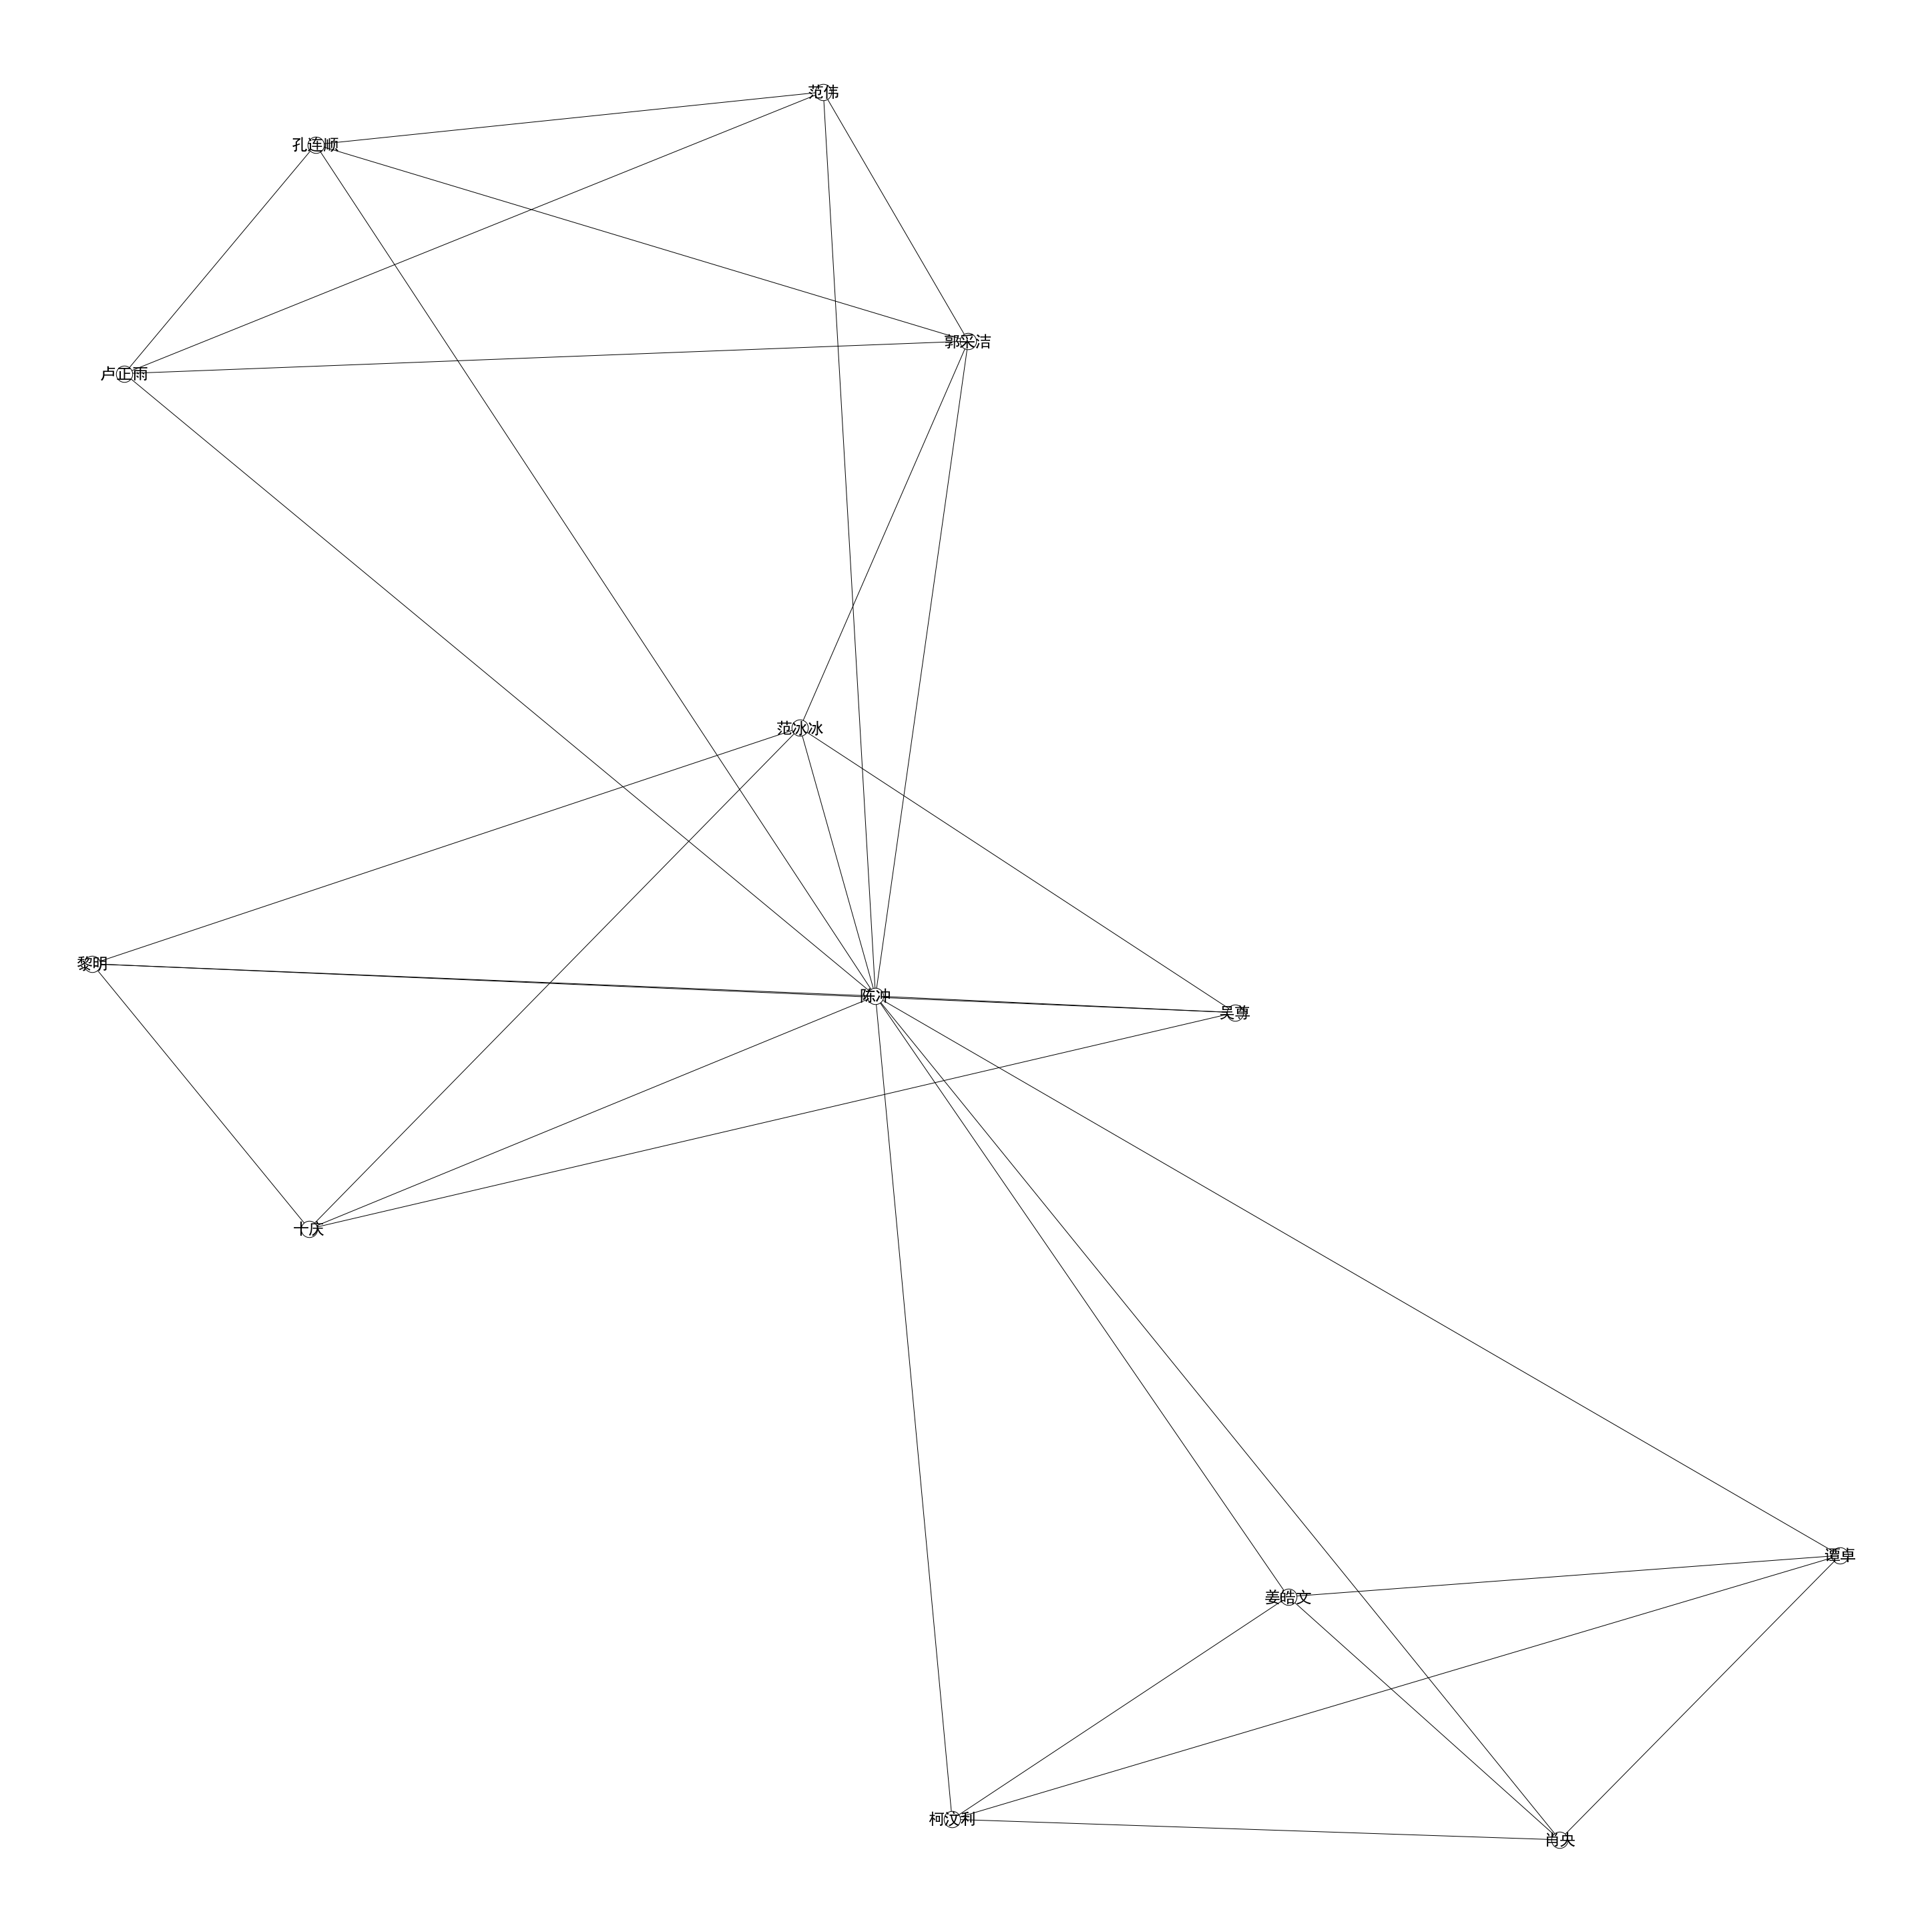

In [28]:
#### Ego-net is the network around a single person

###  Let's choose someone
hub='陈冲'

### Build the ego net 
hub_ego = nx.ego_graph(celebrity_network, hub)

plt.figure(figsize=(40, 40)) 

# # Draw graph
pos = nx.spring_layout(hub_ego)

options = {
    "font_size": 24,
    "node_size": 600,
    "node_color": "white",
    "edgecolors": "black" ,   "width": 1,
}

nx.draw(hub_ego, pos, with_labels=True, **options)

# options = {
#     "node_size": 500,
#     "node_color": "white",
#     "edgecolors": "black"}

# # Draw ego as large and red
# nx.draw_networkx_nodes(hub_ego, pos, nodelist=[hub], **options)

plt.show()

### Building Geographical Network

In [63]:
homeplace_network = hmcpt_df[~hmcpt_df['homeplace'].isna()][['name', 'homeplace']].reset_index(drop=True)

homeplace_network.head()

,name,homeplace
0,苏尚卿,广西
1,杨洋,上海
2,吴京,北京
3,冯小刚,北京
4,李程彬,台湾


In [64]:
Geo_Mapping_Dict = {'厦门':'福建', '哈尔滨':'黑龙江', '唐山':'河北', '西安':'陕西'}

In [65]:
homeplace_network['Sorted_Homeplace'] = [item if item not in Geo_Mapping_Dict.keys() else Geo_Mapping_Dict[item] for item in homeplace_network.homeplace]


homeplace_network['Peoplelist'] = homeplace_network['name'].apply(lambda x: x.split())

In [66]:
agg2 = homeplace_network.groupby('Sorted_Homeplace')['Peoplelist'].agg(sum)

In [67]:
homeplace_agg = agg2.apply(pd.unique).reset_index()

homeplace_agg['network_tuple'] = homeplace_agg['Peoplelist'].apply(lambda x: [*combinations(x, 2)])

In [68]:
homeplace_agg['Peoplelists'] = [list(item)for item in homeplace_agg.Peoplelist]

In [69]:
homeplace_agg = homeplace_agg[homeplace_agg.network_tuple.apply(lambda x : len(x) != 0)].reset_index(drop=True)

In [70]:
Geo_network = nx.Graph()

nodes_list = homeplace_agg.Peoplelists.sum()

print(len(nodes_list))

nodes_list = list(set(nodes_list))

print(len(nodes_list))

Geo_network.add_nodes_from(nodes_list)

edges_list = homeplace_agg.network_tuple.sum()

# June.3rd, we've taken care of the self-join

# edges_list = list(set([item for item in df_bi.collab.sum() if item[0] != item[1]]))

Geo_network.add_edges_from(edges_list)

651
651


In [72]:
aggregated_geo_network_metrics = network_metric_merge(Geo_network, 'collaboration_geo_indicator', 1000)

aggregated_geo_network_metrics.head()

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,collaboration_geo_indicator
0,白敬亭,70,0.107692,0.0,0.107692,1.362673e-12,1
1,谢钢,13,0.020000,0.0,0.020000,8.245748e-84,1
2,潘之琳,24,0.036923,0.0,0.036923,2.234804e-58,1
3,蔡明,70,0.107692,0.0,0.107692,1.362673e-12,1
4,马德钟,90,0.138462,0.0,0.138462,1.048284e-01,1


In [73]:
aggregated_geo_network_metrics.to_csv('~/a_Research/Output/aggregated_geo_network_metrics.csv', index = False)

### Final_Combined_Data

In [103]:
Final_Combined = nx.Graph()

In [104]:
Final_Combined.add_edges_from(celebrity_network.edges)
Final_Combined.add_edges_from(kin_network.edges)
Final_Combined.add_edges_from(alumni_network.edges)
Final_Combined.add_edges_from(Geo_network.edges)

In [105]:
aggregated_final_network_metrics = network_metric_merge(Final_Combined, 'aggregated_final_network_metrics', 100000)

aggregated_final_network_metrics.head()

,celebrity,degrees,degrees_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,aggregated_final_network_metrics
0,冯大年,3,0.001119,0.000000,0.001119,2.540417e-64,1
1,王成,3,0.001119,0.000000,0.001119,2.540417e-64,1
2,徐程程,3,0.001119,0.000000,0.001119,2.540417e-64,1
3,李铭祖,3,0.001119,0.000000,0.001119,2.540417e-64,1
4,严屹宽,6,0.002237,0.000037,0.289102,1.108750e-03,1


In [106]:
aggregated_final_network_metrics.to_csv('~/a_Research/Output/aggregated_final_network_metrics.csv', index = False)